In [33]:
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import scienceplots
%matplotlib inline

from nanonets import Simulation
from nanonets.utils import prepare_for_fitness_calculation, fitness, abundance, abundance_plot, get_best_logic_gate, display_network_currents

plt.style.use(["science","bright"])
N_PARTICLES     = 9
N_ELECTRODES    = 8
ON_STATE        = 0.01
V_CONTROL       = 0.05
GATES           = ['AND', 'OR', 'XOR', 'NAND', 'NOR', 'XNOR']

In [25]:
df              = pd.read_csv(f"Nx={N_PARTICLES}_Ny={N_PARTICLES}_Ne={N_ELECTRODES}.csv")
df              = prepare_for_fitness_calculation(df, N_e=8, input_cols=["E1","E3"], on_state=ON_STATE)
df_fitness      = fitness(df, input_cols=["E1","E3"], on_state=ON_STATE)
df_abundance    = abundance(df_fitness)

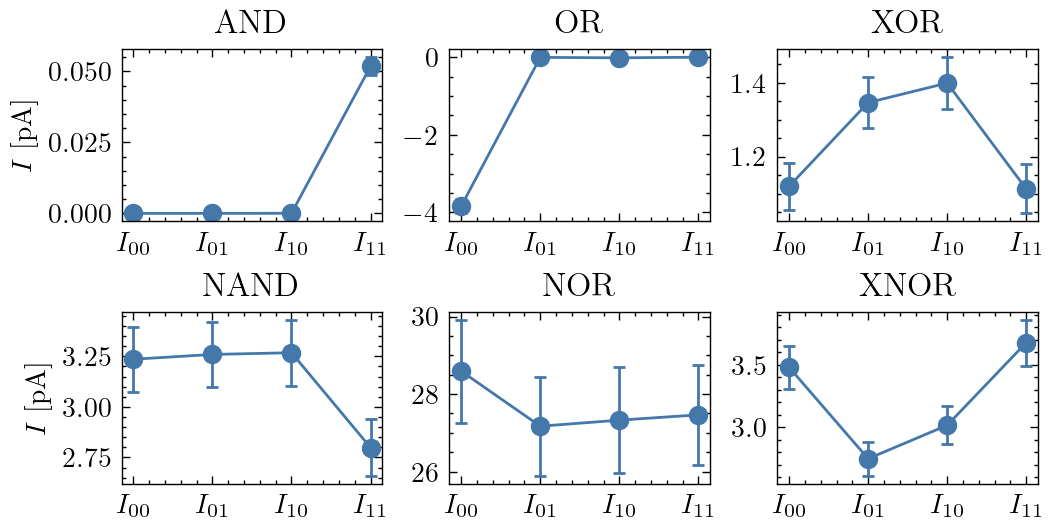

In [26]:
n   = 0
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.5)
for i, gate in enumerate(GATES):
    ax = fig.add_subplot(2,3,i+1)
    best_gate = get_best_logic_gate(df, df_fitness, gate).sort_values(by=['E1','E3']).reset_index(drop=True)
    ax.errorbar([0,1,2,3], best_gate['Observable'].values*1e-6, best_gate['Error'].values*1e-6, marker='o', capsize=2)
    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels(["$I_{00}$","$I_{01}$","$I_{10}$","$I_{11}$"])
    ax.set_title(gate)
    if i % 3 == 0:
        ax.set_ylabel("$I$ [pA]")

(-15.0, 15.0)

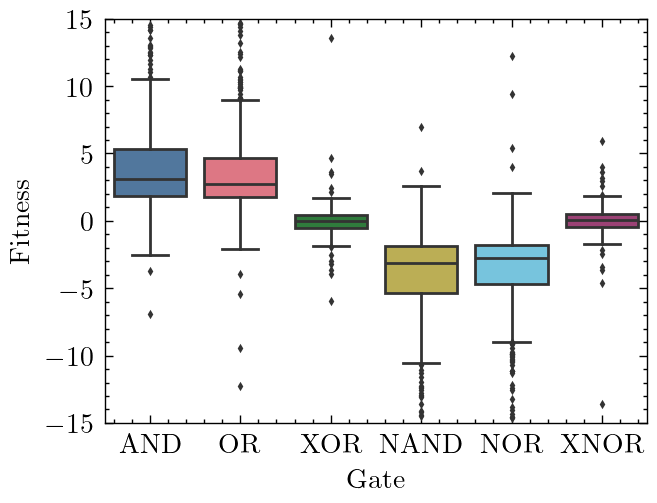

In [27]:
df_box          = df_fitness.loc[:,'AND Fitness':]
df_box.columns  = ["AND", "OR", "XOR", "NAND", "NOR", "XNOR"]
df_box          = df_box.melt(value_name='Fitness', var_name='Gate')

fig, ax = plt.subplots(dpi=200)
ax      = sns.boxplot(df_box, x='Gate', y='Fitness', fliersize=1)
ax.set_ylim(-15,15)

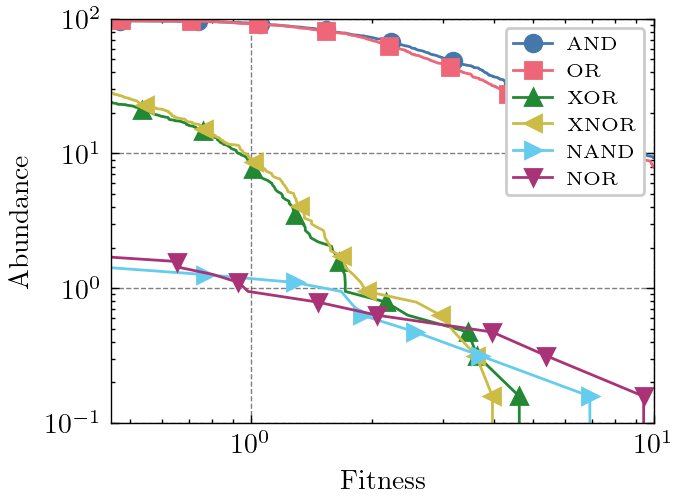

In [28]:
fig, ax = abundance_plot(df_abundance,  y_limits=[0.1,100])

In [22]:
df_pot          = pd.read_csv(f"mean_state_Nx={N_PARTICLES}_Ny={N_PARTICLES}_Ne={N_ELECTRODES}.csv")
df_pot.columns  = [f'E{i}' for i in range(8)] + [i for i in range(N_PARTICLES**2)]
df_pot_best     = get_best_logic_gate(df_pot, df_fitness, 'NAND').sort_values(by=['E1','E3']).reset_index(drop=True)
df_pot_best

,E0,E1,E2,E3,E4,E5,E6,E7,0,1,...,71,72,73,74,75,76,77,78,79,80
0,0.0691,0.00,0.00922,0.00,0.00887,-0.00833,-0.01007,0.0,0.048044,0.034680,...,0.000594,0.006817,0.004794,0.002391,-0.000472,-0.004520,-0.001988,-0.000477,0.000527,-0.000722
1,0.0691,0.00,0.00922,0.01,0.00887,-0.00833,-0.01007,0.0,0.049221,0.036122,...,0.001075,0.007728,0.006087,0.003737,0.000634,-0.003779,-0.001202,0.000474,0.000857,-0.000096
2,0.0691,0.01,0.00922,0.00,0.00887,-0.00833,-0.01007,0.0,0.049229,0.036810,...,0.001017,0.007083,0.005082,0.002942,0.000075,-0.004080,-0.001424,0.000395,0.000897,-0.000097
3,0.0691,0.01,0.00922,0.01,0.00887,-0.00833,-0.01007,0.0,0.050536,0.038430,...,0.001873,0.008790,0.007040,0.004659,0.001379,-0.003263,-0.000493,0.001531,0.001734,0.000914


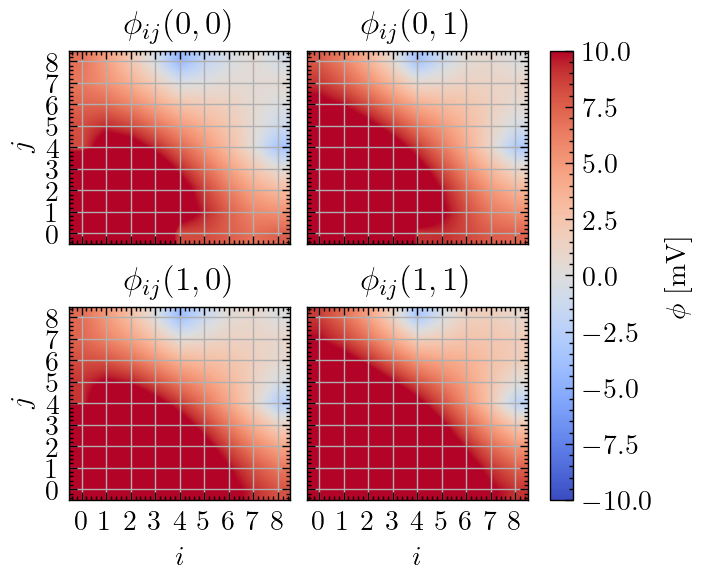

In [23]:
titles = ["$\phi_{ij}(0,0)$","$\phi_{ij}(0,1)$","$\phi_{ij}(1,0)$","$\phi_{ij}(1,1)$"]
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figheight(fig.get_figheight()*1.1)
axs = []
for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    im = ax.imshow(df_pot_best.iloc[i,8:].values.reshape(9,-9)*1000, cmap='coolwarm',
              vmin=-1000*ON_STATE, vmax=1000*ON_STATE, interpolation='bilinear', aspect='auto')
    ax.invert_yaxis()
    ax.set_title(titles[i])
    ax.grid()
    if i % 2 == 0:
        ax.set_yticks(np.arange(N_PARTICLES))
        ax.set_ylabel("$j$")
    else:
        ax.set_yticks(np.arange(N_PARTICLES))
        ax.set_yticklabels("")
    if i >= 2:
        ax.set_xticks(np.arange(N_PARTICLES))
        ax.set_xlabel("$i$")
    else:
        ax.set_xticks(np.arange(N_PARTICLES))
        ax.set_xticklabels("")
    axs.append(ax)
cb = fig.colorbar(im, ax=axs, shrink=1.0, label="$\phi$ [mV]")

In [228]:
import networkx as nx
import ast
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

def create_net_flow_graph(data):
    """
    Processes a dictionary of bi-directional edge weights and builds a
    NetworkX DiGraph representing the net flow.

    Args:
        data (dict): A dictionary where keys are string representations of
                     tuples '(source, target)' and values are float weights.

    Returns:
        nx.DiGraph: A NetworkX directed graph object where edges represent the
                    net flow and have a 'weight' attribute.
    """
    # Initialize a directed graph
    G = nx.DiGraph()
    processed_pairs = set()

    for key_str, weight in data.items():
        # Safely convert the string key to a tuple of integers
        u, v = ast.literal_eval(key_str)

        # Skip if we've already processed this pair in either direction
        if (u, v) in processed_pairs or (v, u) in processed_pairs:
            continue

        # Find the reverse path and its weight
        reverse_key_str = f'({v}, {u})'
        reverse_weight = data.get(reverse_key_str, 0)

        # Determine the direction and calculate the net weight
        if weight >= reverse_weight:
            source, target = u, v
            net_weight = weight - reverse_weight
        else:
            source, target = v, u
            net_weight = reverse_weight - weight
        
        # Add the directed edge to the graph with the net_weight
        G.add_edge(source, target, weight=net_weight)

        # Mark this pair as processed
        processed_pairs.add((u, v))

    return G

def display_net_flow_graph(net_graph: nx.DiGraph, ax=None, pos=None, node_color='#348ABD',
                           node_size=40, font_size=None, cmap=plt.cm.Reds, vmin=None, vmax=None, log_sacle=False):
    
    # --- 1. Setup Figure and Axes ---
    if ax is None:
        fig, ax = plt.subplots(dpi=200)
    else:
        fig = ax.get_figure()

    # --- 2. Calculate Node Positions ---
    if pos is None:
        pos = nx.kamada_kawai_layout(net_graph)

    # --- 3. Get Edge Weights for Coloring ---
    weights = [net_graph[u][v]['weight'] for u, v in net_graph.edges()]
    # Use log scale for better color distribution with wide-ranging data
    if log_sacle:
        new_weights = np.log1p(np.array(weights))
        norm_min    = np.log1p(vmin) if vmin is not None else min(new_weights)
        norm_max    = np.log1p(vmax) if vmax is not None else max(new_weights)
    else:
        new_weights = np.array(weights)
        norm_min    = vmin if vmin is not None else min(new_weights)
        norm_max    = vmax if vmax is not None else max(new_weights)

    # --- 4. Draw the Graph Components ---
    nx.draw(net_graph, pos, node_color=node_color, node_size=node_size, ax=ax,
            edge_color=new_weights, edge_cmap=cmap, arrowstyle='-|>', arrowsize=8, width=1,
            edge_vmin=norm_min, edge_vmax=norm_max)
    
    if font_size is not None:
        nx.draw_networkx_labels(net_graph, pos, font_size=font_size, ax=ax)
        
    ax.axis('off')
    
    return fig, ax

In [231]:
topo = {"Nx": N_PARTICLES, "Ny": N_PARTICLES,
        "e_pos" : [[0,0], [int((N_PARTICLES-1)/2),0], [N_PARTICLES-1,0],
                    [0,int((N_PARTICLES-1)/2)], [0,N_PARTICLES-1],
                    [N_PARTICLES-1,int((N_PARTICLES)/2)],
                    [int((N_PARTICLES)/2),(N_PARTICLES-1)], [N_PARTICLES-1,N_PARTICLES-1]],
        "electrode_type" : ['constant']*N_ELECTRODES}

sim_class       = Simulation(topo, pack_optimizer=False)
pos             = sim_class.get_positions()
pos             = {(key+8 if key >= 0 else (abs(key)-1)) : (val) for key, val in pos.items()}
df_curr         = pd.read_csv(f"net_currents_Nx={N_PARTICLES}_Ny={N_PARTICLES}_Ne={N_ELECTRODES}.csv")

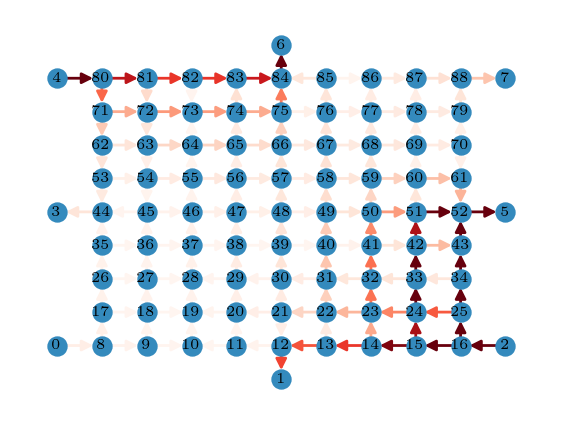

In [241]:
net_graph   = create_net_flow_graph(df_curr.iloc[0,:].to_dict())
fig, ax     = display_net_flow_graph(net_graph, pos=pos, vmin=0, vmax=1e8, log_sacle=False, font_size=5)

Top 10 Most Critical 'Bridge' Conductors:
 Node  Betweenness_Centrality
   47                0.096134
   56                0.091432
   57                0.089472
   46                0.079154
   66                0.076149
   68                0.067529
   67                0.066353
   45                0.052638
   77                0.051724
   36                0.047806


(<Figure size 700x525 with 1 Axes>, <Axes: >)

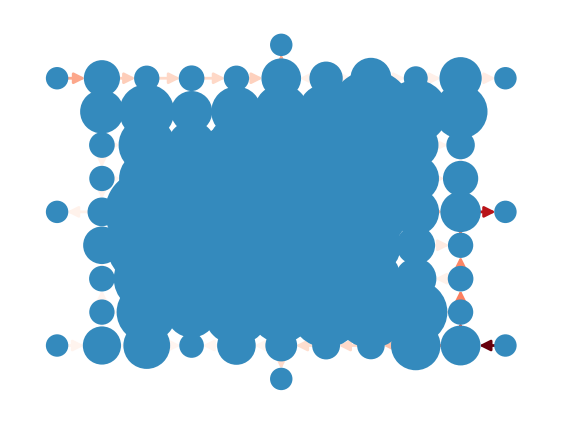

In [276]:
# Create a new graph attribute for 'resistance' to not overwrite 'weight'
for u, v, data in net_graph.edges(data=True):
    # Add a small epsilon to avoid division by zero if current is 0
    epsilon = 1e-12 
    net_graph.edges[u, v]['resistance'] = 1 / (data['weight'] + epsilon)

# --- 2. Calculate Betweenness Centrality ---
# We tell the algorithm to use our new 'resistance' attribute as the weight
betweenness = nx.betweenness_centrality(net_graph, weight='resistance', normalized=True)

# --- 3. Display as a Sorted List ---
# Use pandas for a clean, sorted table display
centrality_df = pd.DataFrame(betweenness.items(), columns=['Node', 'Betweenness_Centrality'])
top_10_nodes = centrality_df.sort_values(by='Betweenness_Centrality', ascending=False).head(10)

print("Top 10 Most Critical 'Bridge' Conductors:")
print(top_10_nodes.to_string(index=False))

# --- 4. Display as a Visualization ---

# Get centrality values to use for node sizes
node_sizes = np.array(list(betweenness.values()))
# Scale the sizes for better visualization (e.g., from 50 to 1500)
scaled_node_sizes = 50 + 1450 * (node_sizes - np.min(node_sizes)) / np.ptp(node_sizes)

# Plot the graph, passing the centrality-based sizes to our function
fig, ax = plt.subplots(dpi=200)
display_net_flow_graph(
    net_graph, 
    pos=pos,
    ax=ax, 
    node_size=scaled_node_sizes, # Use centrality for node size
)

In [271]:
nx.betweenness_centrality(net_graph, weight='weight')

{0: 0.0,
 8: 0.007445141065830722,
 12: 0.003918495297805643,
 1: 0.0,
 2: 0.0,
 16: 0.00849007314524556,
 44: 0.0024817136886102404,
 3: 0.0,
 4: 0.0,
 80: 0.006269592476489029,
 52: 0.008881922675026124,
 5: 0.0,
 84: 0.008359456635318705,
 6: 0.0,
 88: 0.010057471264367818,
 7: 0.0,
 9: 0.013845350052246606,
 17: 0.0005224660397074191,
 10: 0.0,
 18: 0.026645768025078374,
 11: 0.007706374085684431,
 19: 0.08294148380355278,
 20: 0.07366771159874609,
 13: 0.0,
 21: 0.062304075235109724,
 14: 0.023119122257053294,
 22: 0.0574712643678161,
 15: 0.01619644723092999,
 23: 0.04467084639498433,
 24: 0.008098223615464995,
 25: 0.00026123301985370953,
 26: 0.0003918495297805643,
 27: 0.03774817136886103,
 28: 0.1206896551724138,
 29: 0.029388714733542324,
 30: 0.024033437826541278,
 31: 0.018416927899686523,
 32: 0.012539184952978058,
 33: 0.006400208986415884,
 34: 0.0,
 35: 0.0,
 36: 0.04885057471264368,
 37: 0.1741118077324974,
 38: 0.02089864158829676,
 39: 0.01724137931034483,
 40: 0.01

In [264]:
nx.community.louvain_communities(net_graph, weight='weight')

[{0, 8, 9, 17, 26, 35},
 {1, 11, 12},
 {2, 15, 16, 25},
 {3, 44},
 {4, 53, 62, 71, 72, 73, 80, 81},
 {5, 51, 52},
 {6, 74, 75, 82, 83, 84},
 {7, 77, 78, 79, 86, 87, 88},
 {18, 27, 36},
 {13, 14},
 {24, 33, 42},
 {58, 67, 76, 85},
 {21, 22, 23, 31, 32, 40, 41, 49, 50},
 {10, 19, 28, 37},
 {20, 29, 38},
 {34, 43},
 {30, 39, 48},
 {45, 46, 47, 54, 55, 56},
 {59, 60, 61, 68, 69, 70},
 {57, 63, 64, 65, 66}]

In [270]:
source_node = 12
sink_node   = 88
nx.maximum_flow(net_graph, source_node, sink_node, capacity='weight')

(690418.826318968,
 {0: {8: 0},
  8: {9: 0, 17: 0},
  12: {1: 0, 11: 690418.826318968},
  1: {},
  2: {16: 0},
  16: {15: 0, 25: 0},
  44: {3: 0},
  3: {},
  4: {80: 0},
  80: {71: 0, 81: 0},
  52: {5: 0},
  5: {},
  84: {6: 0},
  6: {},
  88: {7: 0},
  7: {},
  9: {10: 0, 18: 0},
  17: {18: 0, 26: 0},
  10: {19: 258771.79813722623},
  18: {19: 0, 27: 0},
  11: {10: 258771.79813722623, 20: 431647.02818174177},
  19: {28: 258771.79813722623},
  20: {19: 0, 29: 431647.02818174177},
  13: {12: 0, 22: 0},
  21: {12: 0, 20: 0, 30: 0},
  14: {13: 0, 23: 0},
  22: {21: 0, 31: 0},
  15: {14: 0, 24: 0},
  23: {22: 0, 32: 0},
  24: {23: 0, 33: 0},
  25: {24: 0, 34: 0},
  26: {27: 0, 35: 0},
  27: {28: 0, 36: 0},
  28: {37: 258771.79813722623},
  29: {28: 0, 38: 431647.02818174177},
  30: {29: 0, 39: 0},
  31: {30: 0, 40: 0},
  32: {31: 0, 41: 0},
  33: {32: 0, 42: 0},
  34: {33: 0, 43: 0},
  35: {36: 0, 44: 0},
  36: {37: 0, 45: 0},
  37: {38: 258771.79813722623, 46: 0},
  38: {39: 325346.079159

---

In [494]:
topo = {"Nx": N_PARTICLES, "Ny": N_PARTICLES,
        "e_pos" : [[0,0], [int((N_PARTICLES-1)/2),0], [N_PARTICLES-1,0],
                    [0,int((N_PARTICLES-1)/2)], [0,N_PARTICLES-1],
                    [N_PARTICLES-1,int((N_PARTICLES)/2)],
                    [int((N_PARTICLES)/2),(N_PARTICLES-1)], [N_PARTICLES-1,N_PARTICLES-1]],
        "electrode_type" : ['constant']*N_ELECTRODES}
sim_class   = Simulation(topo, pack_optimizer=False)
inv_cap     = sim_class.get_inv_capacitance_matrix()
e_cap       = sim_class.get_electrode_capacitance_matrix().T
Alpha       = (-inv_cap @ e_cap).T
C_ii_inv    = inv_cap.diagonal()
E_ii        = (C_ii_inv*sim_class.ELE_CHARGE_A_C**2)/2
V_ii        = 1000 * E_ii / sim_class.ELE_CHARGE_A_C
E_ii_min    = np.min(E_ii)
V_ii_min    = E_ii_min / sim_class.ELE_CHARGE_A_C

print(f"Charging Energy:\n{E_ii}")
print(f"Minimum Energy:\n{E_ii_min}")
print(f"Minimum Voltage:\n{V_ii_min}")

Charging Energy:
[0.0003931  0.0003666  0.00034988 0.00033781 0.00032368 0.00033781
 0.00034988 0.0003666  0.0003931  0.00036234 0.00032257 0.00030732
 0.00029927 0.00029649 0.00029927 0.00030732 0.00032257 0.00036234
 0.000348   0.00030683 0.00029166 0.00028425 0.00028196 0.00028425
 0.00029166 0.00030683 0.000348   0.00033666 0.00029877 0.00028409
 0.0002769  0.0002747  0.0002769  0.00028409 0.00029877 0.00033666
 0.00032276 0.00029601 0.00028176 0.00027465 0.00027247 0.00027465
 0.00028176 0.00029601 0.00032276 0.00033666 0.00029877 0.00028409
 0.0002769  0.0002747  0.0002769  0.00028409 0.00029877 0.00033666
 0.000348   0.00030683 0.00029166 0.00028425 0.00028196 0.00028425
 0.00029166 0.00030683 0.000348   0.00036234 0.00032257 0.00030732
 0.00029927 0.00029649 0.00029927 0.00030732 0.00032257 0.00036234
 0.0003931  0.0003666  0.00034988 0.00033781 0.00032368 0.00033781
 0.00034988 0.0003666  0.0003931 ]
Minimum Energy:
0.0002724681824636792
Minimum Voltage:
0.0017006126482090294


(0.0, 1.5)

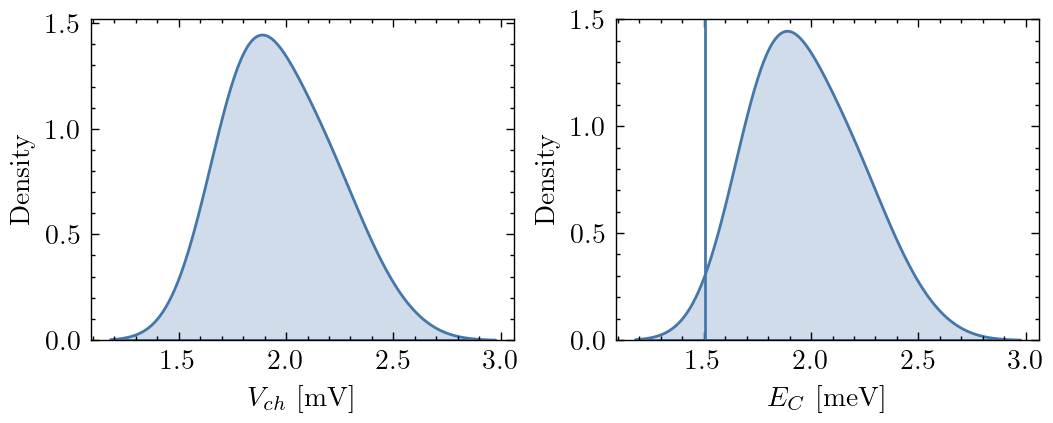

In [495]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.5)
fig.set_figheight(fig.get_figheight()*0.8)
ax  = fig.add_subplot(1,2,1)
ax  = sns.kdeplot(1000 * E_ii / sim_class.ELE_CHARGE_A_C, fill=True, bw_adjust=2)
_   = ax.set_xlabel("$V_{ch}$ [mV]")

ax  = fig.add_subplot(1,2,2)
ax  = sns.kdeplot(1000*6.2415090745*E_ii, fill=True, bw_adjust=2)
_   = ax.set_xlabel("$E_{C}$ [meV]")
ax.vlines(x=3.5*1000*sim_class.KB_EV_PER_K*5, ymin=0, ymax=1.5)
ax.set_ylim(0,1.5)

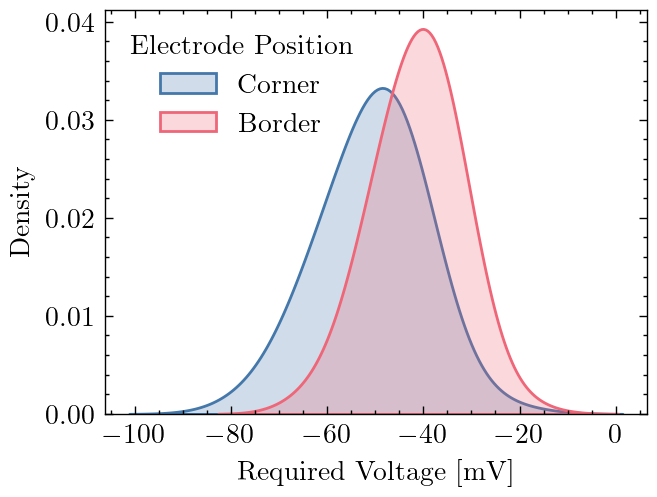

In [486]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.kdeplot(V_ii / Alpha[0,:], fill=True, bw_adjust=2, label='Corner')
ax  = sns.kdeplot(V_ii / Alpha[1,:], fill=True, bw_adjust=2, label='Border')
_   = ax.set_xlabel("Required Voltage [mV]")
_   = ax.legend(loc='upper left', title='Electrode Position')

In [6]:
df = pd.read_csv(f"Nx={N_PARTICLES}_Ny={N_PARTICLES}_Ne={N_ELECTRODES}.csv")
df

,E0,E1,E2,E3,E4,E5,E6,E7,G,Eq_Jumps,Jumps,Observable,Error
0,0.00048,0.000,-0.00500,0.000,-0.00553,0.00930,-0.00081,0.0,0.0,100000.0,474000.0,5.212724e+06,256189.817494
1,0.00553,0.002,0.00039,0.000,-0.00368,0.00904,0.00340,0.0,0.0,100000.0,194000.0,1.086384e+07,522250.189514
2,-0.00813,0.000,-0.00776,0.000,0.00757,0.00031,0.00575,0.0,0.0,100000.0,1594000.0,2.333168e+06,116226.781801
3,-0.00383,0.002,0.00592,0.000,-0.00114,0.00725,0.00651,0.0,0.0,100000.0,116000.0,1.362024e+07,661828.343808
4,0.00364,0.000,0.00708,0.000,-0.00107,0.00928,0.00645,0.0,0.0,100000.0,78000.0,1.911141e+07,918893.328313
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9225,-0.00199,0.002,0.00155,0.002,-0.00347,-0.00882,0.00899,0.0,0.0,100000.0,10000000.0,-1.936522e+04,47774.672476
9226,0.00237,0.000,-0.00529,0.002,0.00535,-0.00793,0.00270,0.0,0.0,100000.0,1256000.0,-2.781021e+06,138441.724616
9227,-0.00409,0.002,-0.00193,0.002,-0.00762,-0.00665,0.00206,0.0,0.0,100000.0,746000.0,-3.068565e+06,152709.791291
9228,0.00506,0.000,0.00877,0.002,0.00264,0.00092,-0.00759,0.0,0.0,100000.0,1140000.0,-3.052228e+06,151710.890804


ValueError: 'x' and 'y' must have the same size

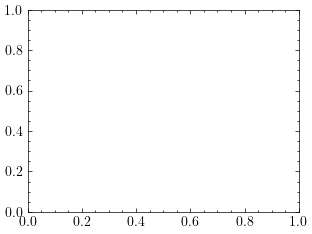

In [7]:
plt.errorbar(range(170), df['Observable'].values*1e-9, df['Error'].values*1e-9)

In [ ]:
values_AND_9    = [0.085337,0.00,-0.03929,0.00,-0.022938,0.010342,0.002624,0.0,0.0]
values_AND_11   = [0.017308,0.00,0.070893,0.00,0.073702,0.038,0.030185,0.0,0.0]
values_AND_13   = [0.089993,0.00,0.063558,0.00,-0.048817,0.011171,0.037835,0.0,0.0]

values_XOR_9    = [-0.094029,0.00,0.051392,0.00,0.03737,-0.040439,-0.043346,0.0,0.0]
values_XOR_11   = [-0.044536,0.00,0.066428,0.00,0.096061,-0.021845,-0.081427,0.0,0.0]
values_XOR_13   = [-0.070379,0.00,0.091417,0.00,0.08231,-0.015387,-0.013483,0.0,0.0]

voltages        = np.tile(np.round(values_AND_13,4), (4,1))
voltages[:,1]   = [0.0,0.0,0.01,0.01]
voltages[:,3]   = [0.0,0.01,0.0,0.01]
voltages

array([[ 0.09  ,  0.    ,  0.0636,  0.    , -0.0488,  0.0112,  0.0378,
         0.    ,  0.    ],
       [ 0.09  ,  0.    ,  0.0636,  0.01  , -0.0488,  0.0112,  0.0378,
         0.    ,  0.    ],
       [ 0.09  ,  0.01  ,  0.0636,  0.    , -0.0488,  0.0112,  0.0378,
         0.    ,  0.    ],
       [ 0.09  ,  0.01  ,  0.0636,  0.01  , -0.0488,  0.0112,  0.0378,
         0.    ,  0.    ]])

In [ ]:
N_p                 = 13
topology_parameter  = {
    "Nx"                : N_p,
    "Ny"                : N_p,
    "Nz"                : 1,
    "e_pos"             : [[0,0,0], [int((N_p-1)/2),0,0], [N_p-1,0,0], 
                            [0,int((N_p-1)/2),0], [0,N_p-1,0], [N_p-1,int((N_p)/2),0],
                            [int((N_p)/2),(N_p-1),0], [N_p-1,N_p-1,0]],
    "electrode_type"    : ['constant','constant','constant','constant',
                           'constant','constant','constant','floating']
}
target_electrode    = len(topology_parameter["e_pos"])-1
sim_dic             =   {
    "error_th"        : 0.05,
    "max_jumps"       : 10000000,
    "eq_steps"        : 100000,
    "jumps_per_batch" : 1000,
    "kmc_counting"    : False,
    "min_batches"     : 5
}
# sim_dic             =   {
#     "error_th"        : 0.0,
#     "max_jumps"       : 100000,
#     "eq_steps"        : 100000,
#     "jumps_per_batch" : 1,
#     "kmc_counting"    : False,
#     "min_batches"     : 0
# }

In [ ]:
list_results        = []
# target_observables  = []
for i in range(10):
    sim_class   = nanonets.simulation(topology_parameter=topology_parameter)
    sim_class.run_const_voltages(voltages=voltages, target_electrode=target_electrode, sim_dic=sim_dic, verbose=False)
    results     = sim_class.return_output_values()
    states      = sim_class.return_potential_landscape()*1000
    net_curr    = pd.DataFrame(sim_class.return_network_currents()[1], columns=sim_class.return_network_currents()[0])
    list_results.append(results)
    # target_observables.append(sim_class.target_observable_values[0]*1000)

In [ ]:
# plt.figure(dpi=200)
# for target_observable in target_observables:
#     plt.plot(target_observable)
#     plt.xlim(0,2000)

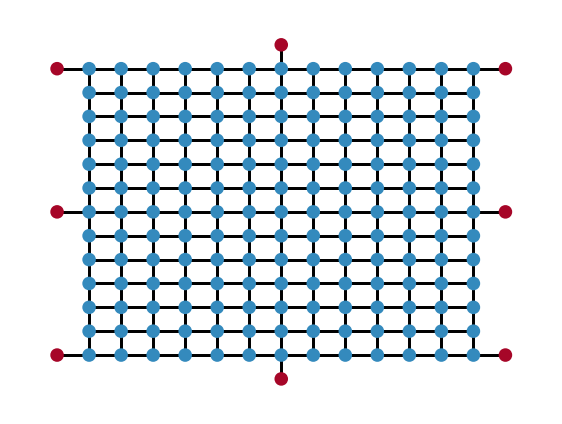

In [ ]:
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
fig, ax = nanonets_utils.display_network(sim_class, fig=fig, ax=ax, node_size=15)

Text(0, 0.5, '$U$ [mV]')

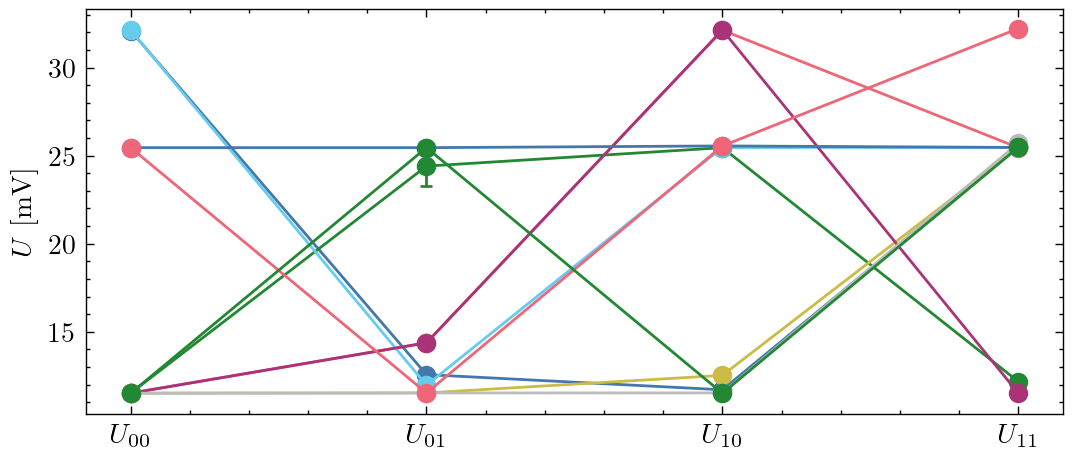

In [ ]:
fig = plt.figure(dpi=200)
fig.set_figwidth(fig.get_figwidth()*1.8)
ax  = fig.add_subplot()
for results in list_results:
    ax.errorbar(["$U_{00}$","$U_{01}$","$U_{10}$","$U_{11}$"],
                results[:,2]*1000, results[:,3]*1000, marker='o', capsize=2)
ax.set_ylabel("$U$ [mV]")

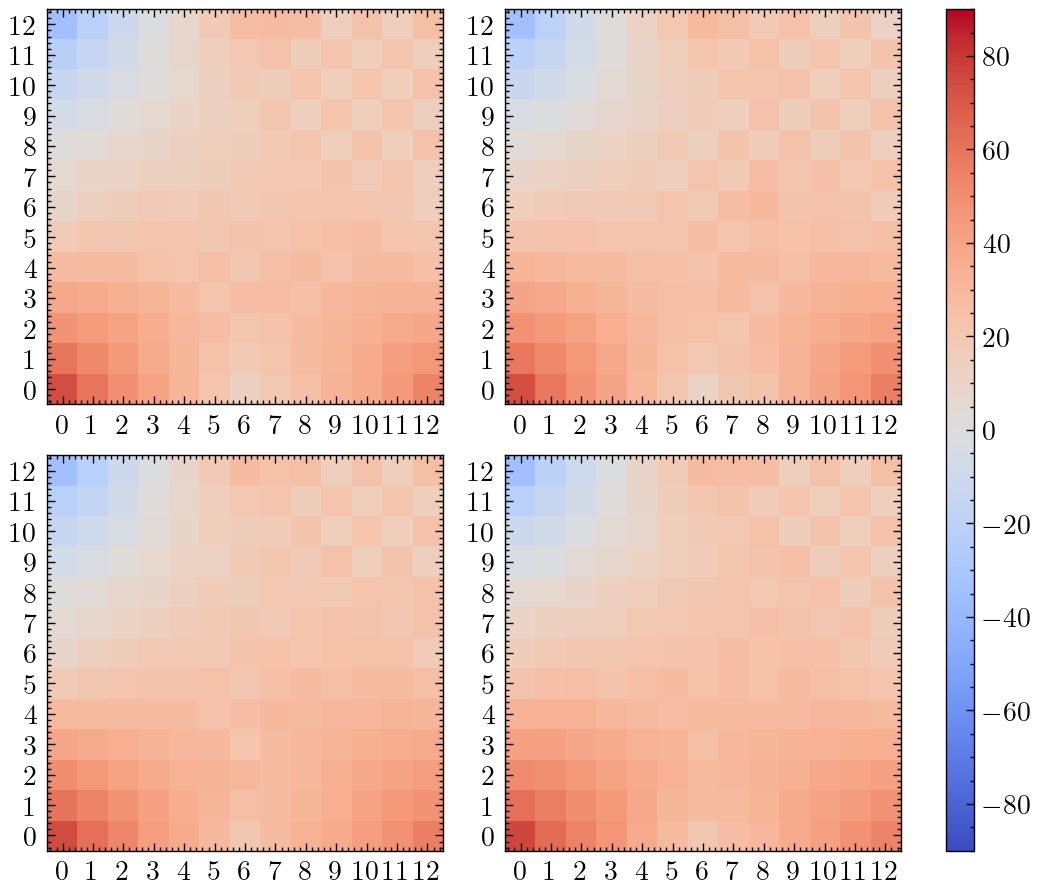

In [ ]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figheight(fig.get_figheight()*1.7)
fig.set_figwidth(fig.get_figwidth()*1.5)

vmin = -np.max(np.abs(states))
vmax = np.max(np.abs(states))

# Create subplots and add imshow plots
axes = []
for i in range(4):
    ax = fig.add_subplot(2, 2, i + 1)
    im = ax.imshow(states[i, 8:].reshape(N_p, -1), cmap='coolwarm', interpolation="nearest", vmin=vmin, vmax=vmax)
    ax.set_xticks(np.arange(N_p))
    ax.set_yticks(np.arange(N_p))
    ax.invert_yaxis()
    axes.append(ax)

# Add a figure-level colorbar
fig.colorbar(im, ax=axes, orientation='vertical', shrink=1.0, label="", aspect=30)

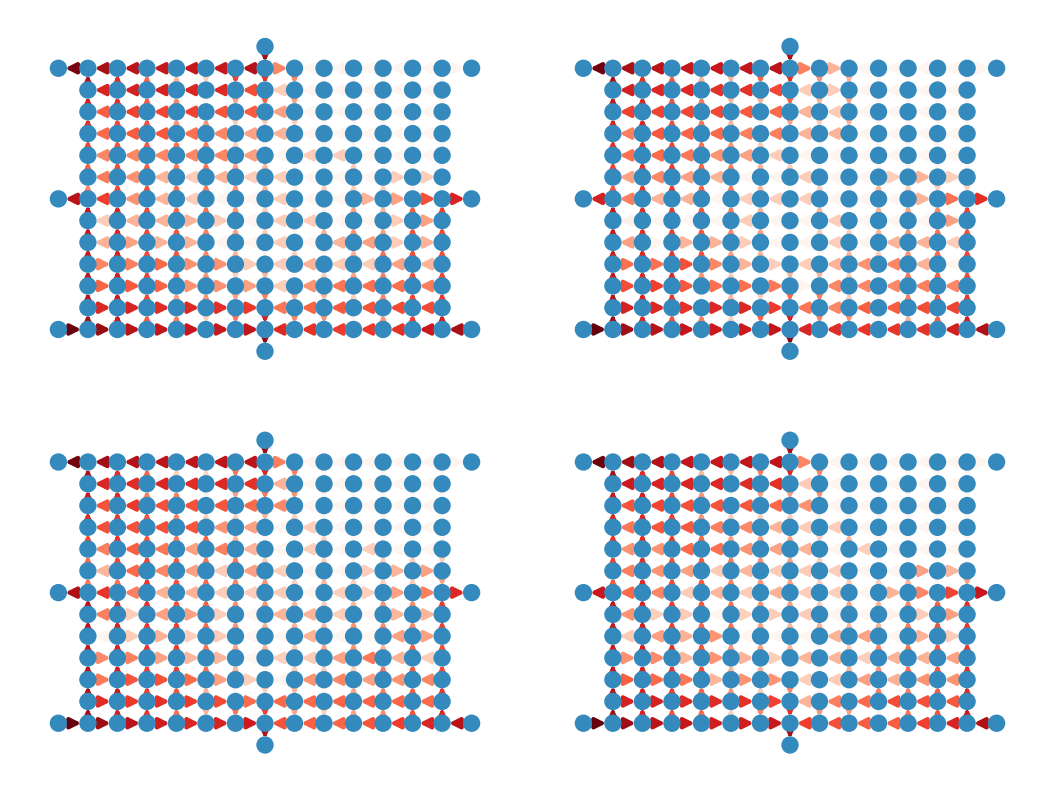

In [ ]:
fig = plt.figure(dpi=300, layout='constrained')

for row in range(4):

    ax      = fig.add_subplot(2,2,row+1)
    fig, ax = nanonets_utils.display_network_currents(df=net_curr, row=row, N_electrodes=8, pos=sim_class.pos,
                                                    fig=fig, ax=ax, node_size=10, arrowsize=5)


In [ ]:
import networkx as nx

G = nx.DiGraph()
G.add_edges_from(net_curr.columns)

last_node   = np.max(G.edges)
distances   = [nx.shortest_path_length(G=G, source=i, target=last_node) for i in range(N_p*N_p)]
states_mean = np.mean(states,axis=0)[8:]

In [ ]:
state_df = pd.DataFrame([distances,states_mean]).T
state_df

,0,1
0,25.0,73.962427
1,19.0,60.593892
2,13.0,51.121223
3,19.0,42.282099
4,13.0,33.433444
...,...,...
164,12.0,24.065276
165,11.0,16.947411
166,10.0,21.058220
167,9.0,16.436487


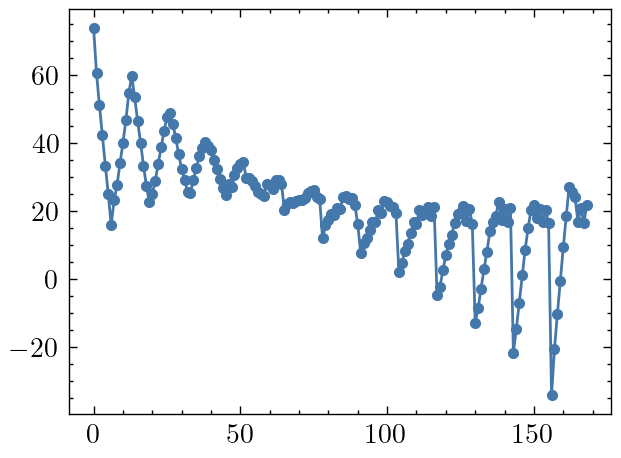

In [ ]:
plt.figure(dpi=200)
plt.plot(states_mean, '.-')

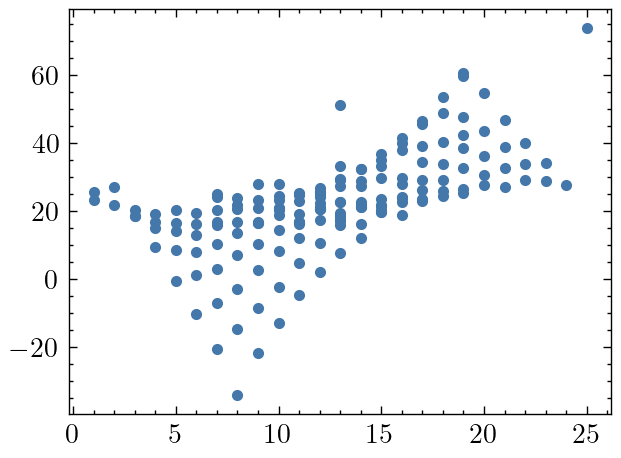

In [ ]:
plt.figure(dpi=200)
plt.plot(distances, np.mean(states,axis=0)[8:], '.')

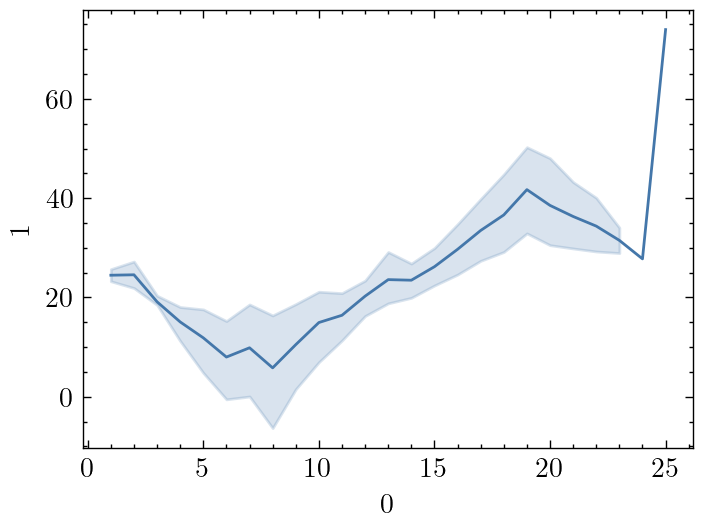

In [ ]:
fig = plt.figure(dpi=200, layout='constrained')
ax  = fig.add_subplot()
ax  = sns.lineplot(data=state_df, x=0, y=1, ax=ax, markers=True)